# **Title:** Cross-Domain Sentiment Analysis: Evaluating Model Performance from Electronics to Cosmetics Product Reviews

## Part 03: Model Building, Evaluation & hypertuning: Model 2 BiLSTM Sentiment Classifier

## Import Necessary Libraries

In [ ]:
# Basic Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,confusion_matrix,classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping


## Connect to drive

In [ ]:
# Connect  to drive to load dataset

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Load Cleaned Data Set

In [ ]:
# Load cleaned dataset to train model

amazon_electronics_df = pd.read_csv('/content/drive/MyDrive/amazon_electronics_electronics_reviews_cleaned.csv')
sephora_skincare_df = pd.read_csv('/content/drive/MyDrive/sephora_skincare_skincare_reviews_cleaned.csv')

In [ ]:
# Show loaded dataset

amazon_electronics_df.head()

,Review,Rating,sentiment,review_length,polarity,label
0,well trying box towersthat sounded like music ...,5,positive,194,0.153092,2
1,ordered one wife one reading negative review p...,5,positive,140,0.220424,2
2,muy buen producto full juegos fhd hay problema...,5,positive,24,0.350000,2
3,sound quality unit phenomenal bose sounddock w...,5,positive,93,0.268527,2
4,good keeping cpu cool also downt forget downlo...,4,positive,24,0.525000,2


In [ ]:
# Show loaded dataset

sephora_skincare_df.head()

,Review,Rating,sentiment,review_length,polarity,label
0,best eye serum ever used well worth money boug...,5,positive,81,0.036944,2
1,helped much stubborn texture purchase life,5,positive,12,0.312500,2
2,honestly not like product nothing seem make br...,2,negative,20,0.100000,0
3,okay started quarantine trying find skin routi...,5,positive,113,0.236111,2
4,good work wonder redness away almost immediate...,5,positive,16,0.562500,2


## Train–Test Split

In [ ]:
# Split amazon_electronics dataset into train (80%) and test (20%)

X_train, X_test, y_train, y_test = train_test_split(amazon_electronics_df['Review'],amazon_electronics_df['label'],train_size=0.80,random_state=50,stratify=amazon_electronics_df['label'])

print("Training set size:", len(X_train))
print("Validation set size:", len(X_test))


Training set size: 7992
Validation set size: 1999


Note: No train test split for sephora_skincare Dataset but keep separate for cross-domain testing

In [ ]:
# Prepare cross-domain test set (Sephora skincare reviews)

X_test_cross = sephora_skincare_df['Review']      # Text data for cross-domain testing
y_test_cross = sephora_skincare_df['label']       # Ground-truth sentiment labels

## Model 2: BiLSTM Sentiment Classifier

### Tokenization & Padding



In [ ]:
max_words = 10000   # vocabulary size
max_len = 100       # max sequence length

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>") #OOV = Out-Of-Vocabulary
tokenizer.fit_on_texts(X_train)

# Convert to sequences and pad
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len, padding='post') # padding='post' pad at the end
X_val_seq   = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len, padding='post')
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test_cross), maxlen=max_len, padding='post')

# Convert labels to numpy arrays
y_train_arr = np.array(y_train)
y_val_arr   = np.array(y_test)
y_test_arr  = np.array(y_test_cross)


## Build the LSTM Model

In [ ]:
# Dimension of word embeddings (size of vector representation for each token)
embedding_dim = 64

# Build a Bidirectional LSTM model for sentiment classification
bilstm_model = Sequential([
    Embedding(input_dim=max_words, output_dim=embedding_dim, input_length=max_len),

    # Bidirectional LSTM layer
    Bidirectional(LSTM(64,return_sequences=True)),

    Bidirectional(LSTM(64)),

    Dense(64, activation='relu'),

    # Dropout layer to reduce overfitting
    Dropout(0.5),

    # Output layer for binary sentiment classification
    Dense(3, activation='softmax')
])

bilstm_model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

# Build the model for summary visualization
bilstm_model.build(input_shape=(None, max_len))

# Print model summary
bilstm_model.summary()


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ (None, 100, 64)        │       640,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ (None, 100, 128)       │        66,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional_1 (Bidirectional) │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 3)              │           195 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 813,315 (3.10 MB)

 Trainable params: 813,315 (3.10 MB)

 Non-trainable params: 0 (0.00 B)

## Train Model

In [ ]:
# Early stopping callback:

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True),
    ModelCheckpoint('best_bilstm_model.keras', save_best_only=True)
]

# Compute class weights
class_weights = class_weight.compute_class_weight(
    'balanced',
    classes=np.unique(y_train),
    y=y_train
)
class_weights_dict = dict(enumerate(class_weights))

# Train the BiLSTM model
history = bilstm_model.fit(
    X_train_seq, y_train_arr,                     # Training sequences and labels
    validation_data=(X_val_seq, y_val_arr),       # Validation set for monitoring generalization
    epochs=10,                                    # Maximum epochs (actual may stop earlier)
    batch_size=64,                                # Smaller batch improves RNN learning stability
    callbacks=[callbacks],                        # Apply early stopping
    verbose=1,                                    # Show training progress
    #class_weight=class_weights_dict
    )


Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 65s 444ms/step - accuracy: 0.7733 - loss: 0.7474 - val_accuracy: 0.7964 - val_loss: 0.5544
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 53s 421ms/step - accuracy: 0.8195 - loss: 0.4927 - val_accuracy: 0.8214 - val_loss: 0.5371
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 83s 426ms/step - accuracy: 0.8602 - loss: 0.3710 - val_accuracy: 0.8194 - val_loss: 0.5950
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 416ms/step - accuracy: 0.8886 - loss: 0.2767 - val_accuracy: 0.7904 - val_loss: 0.6530
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 81s 407ms/step - accuracy: 0.9182 - loss: 0.2020 - val_accuracy: 0.7724 - val_loss: 0.7578


### Plot Training vs Validation Loss

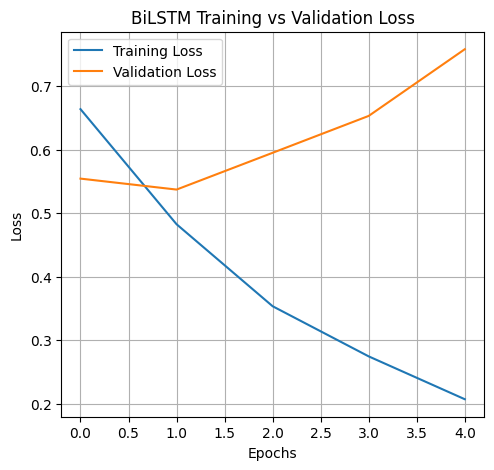

In [ ]:
# Create Figure
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("BiLSTM Training vs Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)

### Plot Training vs Validation Accuracy

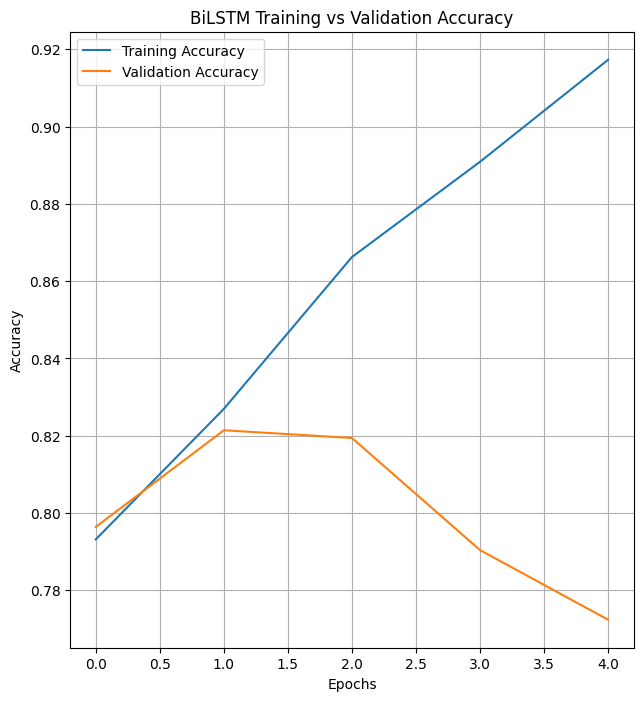

In [ ]:
# Accuracy curve

# Create Figure
plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title("BiLSTM Training vs Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.show()


In [ ]:
# Mount Google Drive to save and access model files
from google.colab import drive
drive.mount('/content/drive')

# Save the trained BiLSTM model to Google Drive in .h5 format
bilstm_model.save('/content/drive/MyDrive/bilstm_sentiment_analysis_model.h5')
print("BiLSTM model saved successfully!")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
BiLSTM model saved successfully!


In [ ]:
# Load the saved model later for evaluation or inference
from tensorflow.keras.models import load_model
bilstm_model = load_model('/content/drive/MyDrive/bilstm_sentiment_analysis_model.h5')

###  Evaluation (In-Domain)

63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step

amazon_electronics (In-Domain) Evaluation:
              precision    recall  f1-score   support

           0       0.67      0.30      0.41       226
           1       0.00      0.00      0.00       178
           2       0.83      0.99      0.90      1595

    accuracy                           0.82      1999
   macro avg       0.50      0.43      0.44      1999
weighted avg       0.74      0.82      0.77      1999



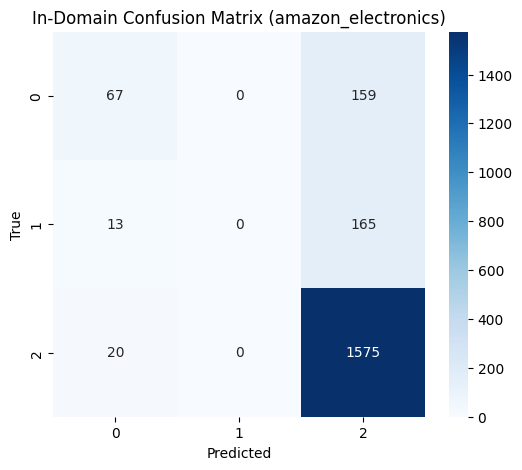

In [ ]:
val_probs = bilstm_model.predict(X_val_seq)
val_preds = np.argmax(val_probs, axis=1)

print("\namazon_electronics (In-Domain) Evaluation:")
print(classification_report(y_val_arr, val_preds))

cm_in = confusion_matrix(y_val_arr, val_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_in, annot=True, fmt='d', cmap='Blues')
plt.title("In-Domain Confusion Matrix (amazon_electronics)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

## Evaluate (Cross-Domain: sephora_skincare)

156/156 ━━━━━━━━━━━━━━━━━━━━ 12s 74ms/step

sephora_skincare (Cross-Domain) Evaluation:
              precision    recall  f1-score   support

           0       0.54      0.12      0.19       540
           1       0.00      0.00      0.00       415
           2       0.82      0.99      0.90      4033

    accuracy                           0.81      4988
   macro avg       0.45      0.37      0.36      4988
weighted avg       0.72      0.81      0.75      4988



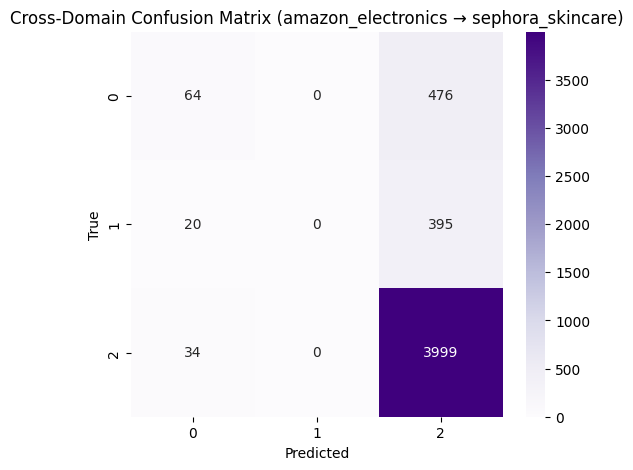

In [ ]:
seph_probs = bilstm_model.predict(X_test_seq)
seph_preds = np.argmax(seph_probs, axis=1)

print("\nsephora_skincare (Cross-Domain) Evaluation:")
print(classification_report(y_test_arr, seph_preds))

cm_cross = confusion_matrix(y_test_arr, seph_preds)
plt.figure(figsize=(6,5))
sns.heatmap(cm_cross, annot=True, fmt='d', cmap='Purples')
plt.title("Cross-Domain Confusion Matrix (amazon_electronics → sephora_skincare)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

### Cross Domain Performance Comparison

In [ ]:

amazon_electronics_acc = accuracy_score(y_val_arr, val_preds)
amazon_electronics_precision = precision_score(y_val_arr, val_preds, average='weighted')
amazon_electronics_recall = recall_score(y_val_arr, val_preds, average='weighted')
amazon_electronics_f1 = f1_score(y_val_arr, val_preds, average='weighted')

sephora_acc = accuracy_score(y_test_arr, seph_preds)
sephora_precision = precision_score(y_test_arr, seph_preds, average='weighted')
sephora_recall = recall_score(y_test_arr, seph_preds, average='weighted')
sephora_f1 = f1_score(y_test_arr, seph_preds, average='weighted')

bilstm_results = pd.DataFrame({
    'Model': ['BiLSTM', 'BiLSTM'],
    'Dataset': ['amazon_electronics (In-domain)', 'sephora_skincare (Cross-domain)'],
    'Accuracy': [amazon_electronics_acc, sephora_acc],
    'Precision': [amazon_electronics_precision, sephora_precision],
    'Recall': [amazon_electronics_recall, sephora_recall],
    'F1-score': [amazon_electronics_f1, sephora_f1]
})

bilstm_results.to_csv('bilstm_results.csv', index=False)

print("\n=== BiLSTM Evaluation Summary ===")
bilstm_results


=== BiLSTM Evaluation Summary ===


,Model,Dataset,Accuracy,Precision,Recall,F1-score
0,BiLSTM,amazon_electronics (In-domain),0.821411,0.737512,0.821411,0.765813
1,BiLSTM,sephora_skincare (Cross-domain),0.814555,0.722650,0.814555,0.747411


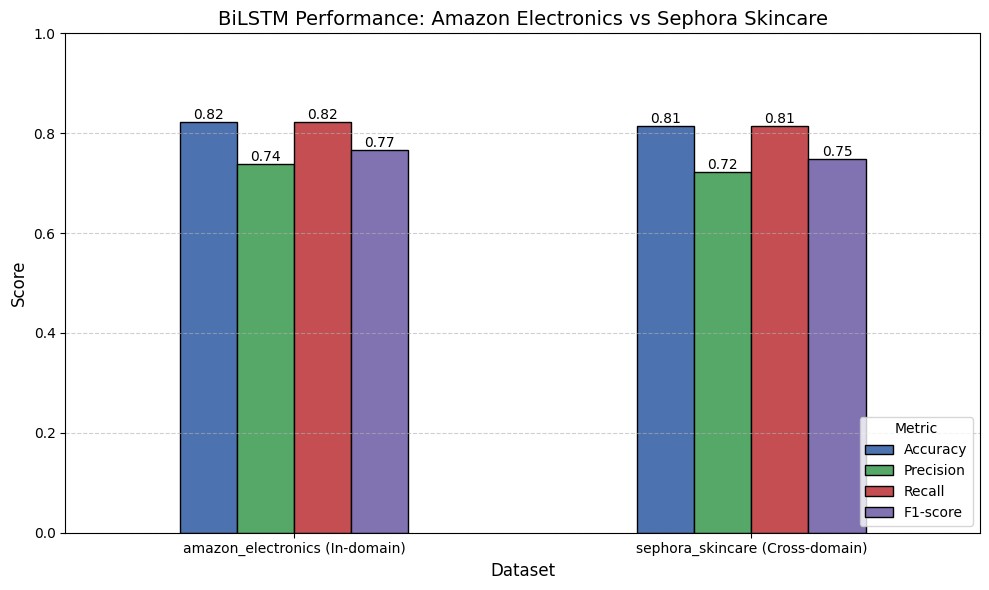

In [ ]:
# Select metrics and set index
metrics = ['Accuracy', 'Precision', 'Recall', 'F1-score']
df_plot = bilstm_results.set_index('Dataset')[metrics]

# Plot
ax = df_plot.plot(
    kind='bar',
    figsize=(10, 6),
    color=['#4C72B0', '#55A868', '#C44E52', '#8172B2'],
    edgecolor='black'
)

# Add title and labels
plt.title('BiLSTM Performance: Amazon Electronics vs Sephora Skincare', fontsize=14)
plt.xlabel('Dataset', fontsize=12)
plt.ylabel('Score', fontsize=12)
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.6)

# Annotate bars with their values
for p in ax.patches:
    height = p.get_height()
    ax.annotate(f'{height:.2f}',
                (p.get_x() + p.get_width() / 2., height),
                ha='center', va='bottom', fontsize=10, rotation=0)

# Adjust legend
plt.legend(title='Metric', loc='lower right')

# Show plot
plt.tight_layout()
plt.show()